# Logistic Regression Modeling

## Pull & Clean Datasets

In [1]:
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_train = pd.read_csv('Data/hate_speech_training.csv')
df_train_2 = pd.read_csv('Data/hate_speech_training_2.csv')
df_train_3 = pd.read_csv('Data/hate_speech_training_3.csv')
df_train_4 = pd.read_csv('Data/hate_speech_training_4.tsv', sep = '\t')
df_train_5 = pd.read_csv('Data/hate_speech_training_5.csv')
df_test = pd.read_csv('Data/hate_speech_test.csv')

In [3]:
df_train = df_train.drop('id', axis = 1) #0 = Not Hate Speech, 1 = Hate Speech

In [4]:
df_train_2 = df_train_2[['tweet', 'class']]
df_train_2['class'] = df_train_2['class'].replace([0], 'hate speech')
df_train_2['class'] = df_train_2['class'].replace([1, 2], 'not hate speech')
df_train_2['class'] = df_train_2['class'].replace(['hate speech'], 1)
df_train_2['class'] = df_train_2['class'].replace(['not hate speech'], 0)
df_train_2.rename(columns = {'class': 'label'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

In [5]:
df_train_3 = df_train_3.drop('index', axis = 1) 
df_train_3.rename(columns = {'post': 'tweet'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

In [6]:
df_train_4 = df_train_4[['text', 'HS']] 
df_train_4.rename(columns = {'text': 'tweet', 'HS': 'label'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

In [7]:
df_train_5['Label'] = df_train_5['Label'].replace(['Hate', 'Non-Asian Aggression'], 1)
df_train_5['Label'] = df_train_5['Label'].replace(['Neutral', 'Counterhate'], 0) 
df_train_5.rename(columns = {'Text': 'tweet', 'Label': 'label'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

In [8]:
dfs = [df_train, df_train_2, df_train_3, df_train_4, df_train_5]
df = pd.concat(dfs)

## Train, Test, Split

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X = df['tweet']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=3,
                                                    test_size=0.20) #80/20 split

## Natural Language Processing (NLP)

The goal here will actually to be to not only use grid searches but to also test both TF-IDF (Term Frequency - Inverse Document Frequency) and Count Vectorizers to see which performs better with each model

### TF-IDF

In [11]:
import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [12]:
sw = stopwords.words('english')

In [13]:
def get_wordnet_pos(treebank_tag):
    
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [14]:
def doc_preparer(doc, stop_words=sw):
 
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

In [15]:
token_docs = [doc_preparer(doc, sw) for doc in X_train]

In [16]:
tfidf = TfidfVectorizer()
X_t, X_val, y_t, y_val = train_test_split(token_docs, y_train,
                                          test_size=0.20, random_state=3)

In [17]:
X_t_vec = tfidf.fit_transform(X_t)
X_t_vec = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(tfidf.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)

In [18]:
X_val_vec = tfidf.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(tfidf.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

### Count Vectorizer

In [43]:
cv = CountVectorizer()
X_c_vec = cv.fit_transform(X_t)
X_c_vec = pd.DataFrame.sparse.from_spmatrix(X_c_vec)
X_c_vec.columns = sorted(cv.vocabulary_)
X_c_vec.set_index(y_t.index, inplace=True)

In [44]:
X_c_val_vec = cv.transform(X_val)
X_c_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_c_val_vec)
X_c_val_vec.columns = sorted(cv.vocabulary_)
X_c_val_vec.set_index(y_val.index, inplace=True)

## Modeling TF-IDF on Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [20]:
lr_tfidf = LogisticRegression()
lr_tfidf.fit(X_t_vec, y_t)

LogisticRegression()

In [21]:
lr_tfidf.score(X_t_vec, y_t)

0.9342319522344853

In [22]:
cross_val_score(lr_tfidf, X_t_vec, y_t, cv = 5)

array([0.92740841, 0.92434694, 0.92457311, 0.92570395, 0.92491236])

In [24]:
lr_tfidf.score(X_val_vec, y_val)

0.92962460425147

In [25]:
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, classification_report

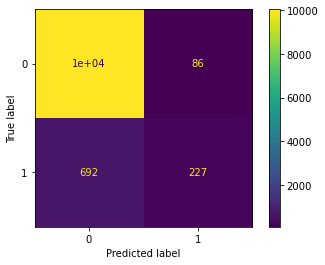

In [26]:
plot_confusion_matrix(lr_tfidf, X_val_vec, y_val);

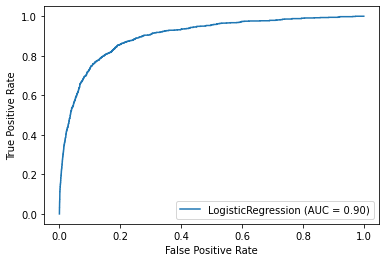

In [27]:
plot_roc_curve(lr_tfidf, X_val_vec, y_val);

In [28]:
y_hat = lr_tfidf.predict(X_val_vec)
print(classification_report(y_pred = y_hat, y_true = y_val))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96     10136
           1       0.73      0.25      0.37       919

    accuracy                           0.93     11055
   macro avg       0.83      0.62      0.67     11055
weighted avg       0.92      0.93      0.91     11055



## Grid Search for TF-IDF on Logistic Regression

In [29]:
from sklearn.model_selection import GridSearchCV
import numpy as np
grid_params = {'C': np.logspace(-3, 3, 7),
              'penalty': ['l1', 'l2']}

In [30]:
gs_tfidf = GridSearchCV(LogisticRegression(),
                 grid_params,
                 verbose = 1,
                 cv = 3,
                 n_jobs = 3)

In [31]:
gs_tfidf.fit(X_t_vec, y_t)

Fitting 3 folds for each of 14 candidates, totalling 42 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  42 out of  42 | elapsed: 34.4min finished


GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=3,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             verbose=1)

In [32]:
gs_tfidf.best_score_

0.9307942779382746

In [33]:
gs_tfidf.best_estimator_

LogisticRegression(C=10.0)

In [34]:
gs_tfidf.best_params_

{'C': 10.0, 'penalty': 'l2'}

## Best Possible Model of Logistic Regression with TF-IDF

In [35]:
lr_best_tfidf = LogisticRegression(C = 10, penalty = 'l2')
lr_best_tfidf.fit(X_t_vec, y_t)

LogisticRegression(C=10)

In [36]:
lr_best_tfidf.score(X_t_vec, y_t)

0.9767504975574453

In [38]:
cross_val_score(lr_best_tfidf, X_t_vec, y_t, cv = 5)

array([0.93170511, 0.93271514, 0.92864413, 0.93147122, 0.93079272])

In [39]:
lr_best_tfidf.score(X_val_vec, y_val)

0.9333333333333333

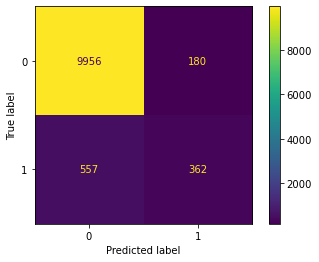

In [40]:
plot_confusion_matrix(lr_best_tfidf, X_val_vec, y_val)

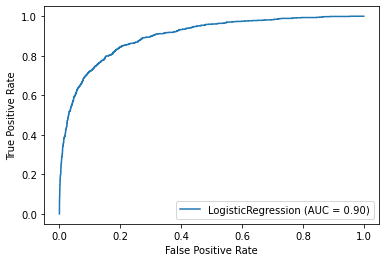

In [41]:
plot_roc_curve(lr_best_tfidf, X_val_vec, y_val)

In [42]:
y_hat_2 = lr_best_tfidf.predict(X_val_vec)
print(classification_report(y_pred = y_hat_2, y_true = y_val))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96     10136
           1       0.67      0.39      0.50       919

    accuracy                           0.93     11055
   macro avg       0.81      0.69      0.73     11055
weighted avg       0.92      0.93      0.93     11055



## Modeling Count Vectorizer on Logistic Regression

In [45]:
lr_cv = LogisticRegression()
lr_cv.fit(X_c_vec, y_t)

LogisticRegression()

In [46]:
lr_cv.score(X_c_vec, y_t)

0.965035281346119

In [48]:
cross_val_score(lr_cv, X_c_vec, y_t, cv = 5)

array([0.93068747, 0.93203664, 0.93000113, 0.92988805, 0.93101888])

In [49]:
lr_cv.score(X_c_val_vec, y_val)

0.9330619629127092

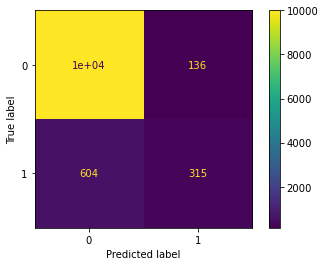

In [50]:
plot_confusion_matrix(lr_cv, X_c_val_vec, y_val)

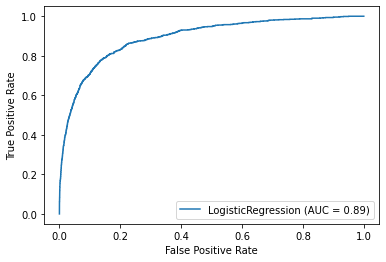

In [51]:
plot_roc_curve(lr_cv, X_c_val_vec, y_val)

In [52]:
y_hat_3 = lr_cv.predict(X_c_val_vec)
print(classification_report(y_pred = y_hat_3, y_true = y_val))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96     10136
           1       0.70      0.34      0.46       919

    accuracy                           0.93     11055
   macro avg       0.82      0.66      0.71     11055
weighted avg       0.92      0.93      0.92     11055



## Grid Search for Count Vectorizer on Logistic Regression

In [55]:
gs_cv = GridSearchCV(LogisticRegression(),
                 grid_params,
                 verbose = 1,
                 cv = 3,
                 n_jobs = 3)

In [57]:
gs_cv.fit(X_c_vec, y_t)

Fitting 3 folds for each of 14 candidates, totalling 42 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  42 out of  42 | elapsed: 36.7min finished


GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=3,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             verbose=1)

In [58]:
gs_cv.best_score_

0.9295956209109507

In [59]:
gs_cv.best_estimator_

LogisticRegression()

In [60]:
gs_cv.best_params_

{'C': 1.0, 'penalty': 'l2'}

## Best Possible Model of Logistic Regression with Count Vectorizer

In [61]:
lr_best_cv = LogisticRegression(C = 1, penalty = 'l2')
lr_best_cv.fit(X_c_vec, y_t)

LogisticRegression(C=1)

In [62]:
lr_best_cv.score(X_c_vec, y_t)

0.965035281346119

In [63]:
cross_val_score(lr_best_cv, X_c_vec, y_t, cv = 5)

array([0.93068747, 0.93203664, 0.93000113, 0.92988805, 0.93101888])

In [64]:
lr_best_cv.score(X_c_val_vec, y_val)

0.9330619629127092

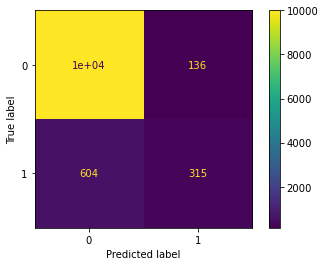

In [65]:
plot_confusion_matrix(lr_best_cv, X_c_val_vec, y_val)

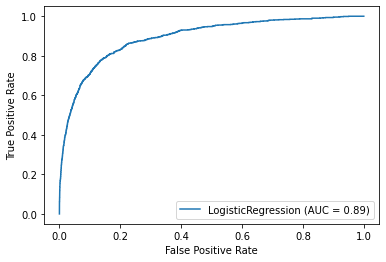

In [66]:
plot_roc_curve(lr_best_cv, X_c_val_vec, y_val)

In [67]:
y_hat_4 = lr_best_cv.predict(X_c_val_vec)
print(classification_report(y_pred = y_hat_4, y_true = y_val))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96     10136
           1       0.70      0.34      0.46       919

    accuracy                           0.93     11055
   macro avg       0.82      0.66      0.71     11055
weighted avg       0.92      0.93      0.92     11055



## Training TFIDF and Count Vectorizer on best possible Logistic Regression Models with Entire Training Set

In [68]:
token_test_docs = [doc_preparer(doc, sw) for doc in X_test]

### TFIDF on Training Set

In [69]:
tfidf_final = TfidfVectorizer()

In [70]:
X_final_t_vec = tfidf_final.fit_transform(token_docs)
X_final_t_vec = pd.DataFrame.sparse.from_spmatrix(X_final_t_vec)
X_final_t_vec.columns = sorted(tfidf_final.vocabulary_)
X_final_t_vec.set_index(y_train.index, inplace=True)

In [71]:
X_final_test_vec = tfidf_final.transform(token_test_docs)
X_final_test_vec  = pd.DataFrame.sparse.from_spmatrix(X_final_test_vec)
X_final_test_vec.columns = sorted(tfidf_final.vocabulary_)
X_final_test_vec.set_index(y_test.index, inplace=True)

### Count Vectorizer on Training Set

In [72]:
cv_final = CountVectorizer()

In [74]:
X_final_c_vec = cv_final.fit_transform(token_docs)
X_final_c_vec = pd.DataFrame.sparse.from_spmatrix(X_final_c_vec)
X_final_c_vec.columns = sorted(cv_final.vocabulary_)
X_final_c_vec.set_index(y_train.index, inplace=True)

In [75]:
X_final_test_c_vec = cv_final.transform(token_test_docs)
X_final_test_c_vec  = pd.DataFrame.sparse.from_spmatrix(X_final_test_c_vec)
X_final_test_c_vec.columns = sorted(cv_final.vocabulary_)
X_final_test_c_vec.set_index(y_test.index, inplace=True)

### Best Possible Logistic Regression Model on Entire Training Set Using TF-IDF

In [77]:
lr_final_tfidf = LogisticRegression(C = 10, penalty = 'l2')
lr_final_tfidf.fit(X_final_t_vec, y_train)

LogisticRegression(C=10)

In [78]:
lr_final_tfidf.score(X_final_t_vec, y_train)

0.9749235584664653

In [80]:
cross_val_score(lr_final_tfidf, X_final_t_vec, y_train, cv =5)

array([0.93441882, 0.93305591, 0.93350823, 0.93432242, 0.93314637])

In [81]:
lr_final_tfidf.score(X_final_test_vec, y_test)

0.9337820234476769

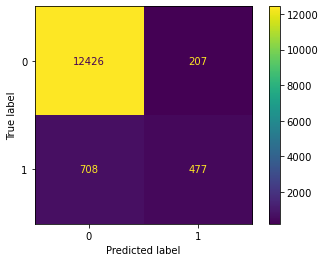

In [82]:
plot_confusion_matrix(lr_final_tfidf, X_final_test_vec, y_test)

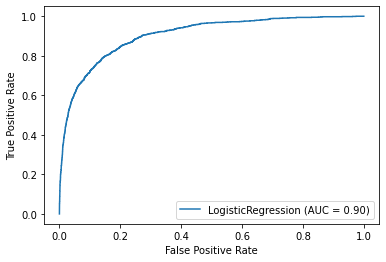

In [83]:
plot_roc_curve(lr_final_tfidf, X_final_test_vec, y_test)

In [84]:
y_hat_5 = lr_final_tfidf.predict(X_final_test_vec)
print(classification_report(y_pred = y_hat_5, y_true = y_test))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96     12633
           1       0.70      0.40      0.51      1185

    accuracy                           0.93     13818
   macro avg       0.82      0.69      0.74     13818
weighted avg       0.92      0.93      0.93     13818



### Best Possible Logistic Regression Model on Entire Training Set Using Count Vectorizer

In [85]:
lr_final_cv = LogisticRegression(C = 1, penalty = 'l2')
lr_final_cv.fit(X_final_c_vec, y_train)

LogisticRegression(C=1)

In [86]:
lr_final_cv.score(X_final_c_vec, y_train)

0.9644840874961553

In [87]:
cross_val_score(lr_final_cv, X_final_c_vec, y_train, cv = 5)

array([0.93215739, 0.9317894 , 0.931518  , 0.93115614, 0.93287498])

In [88]:
lr_final_cv.score(X_final_test_c_vec, y_test)

0.9316109422492401

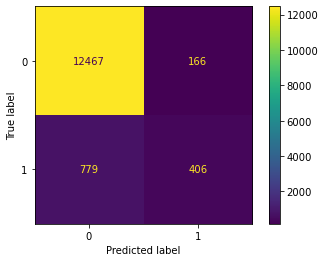

In [89]:
plot_confusion_matrix(lr_final_cv, X_final_test_c_vec, y_test)

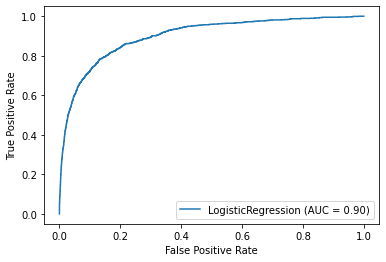

In [90]:
plot_roc_curve(lr_final_cv, X_final_test_c_vec, y_test)

In [91]:
y_hat_6 = lr_final_cv.predict(X_final_test_c_vec)
print(classification_report(y_pred = y_hat_6, y_true = y_test))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96     12633
           1       0.71      0.34      0.46      1185

    accuracy                           0.93     13818
   macro avg       0.83      0.66      0.71     13818
weighted avg       0.92      0.93      0.92     13818

